In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ColabNotebooks/Project_D

/content/drive/MyDrive/ColabNotebooks/Project_D


In [3]:
!source /content/drive/MyDrive/ColabNotebooks/Project_D/myenv/bin/activate

In [4]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [6]:
np.random.seed(42)

In [7]:
# Load and clean data
train_data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Project_D/new_new_train_data.csv').dropna()
test_data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Project_D/new_new_test_data.csv').dropna()

In [8]:
# Remove unwanted classes
labels_to_remove = ['OTHER', 'IP']
train_data = train_data[~train_data['category_code'].isin(labels_to_remove)]
test_data = test_data[~test_data['category_code'].isin(labels_to_remove)]

In [9]:
# Encode labels
le = LabelEncoder()
train_data['category_code'] = le.fit_transform(train_data['category_code'])
test_data['category_code'] = le.transform(test_data['category_code'])

X_train_raw = train_data['content'].fillna('')
y_train = train_data['category_code']
X_test_raw = test_data['content'].fillna('')
y_test = test_data['category_code']

In [10]:
# Improved vectorizer and feature selector
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5), max_features=20000)
selector = SelectKBest(score_func=chi2, k=10000)

In [11]:
# Updated models (Ridge removed, use LogisticRegressionCV instead for soft voting)
models = {
    "LogRegCV": LogisticRegressionCV(cv=3, max_iter=1000, multi_class='multinomial', solver='lbfgs', n_jobs=-1),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
# Cross-validation
best_model = None
best_score = 0
results = {}

print("Cross-validating models...")
for name, model in tqdm(models.items()):
    pipeline = Pipeline([
        ('tfidf', tfidf),
        ('select', selector),
        ('clf', model)
    ])
    scores = cross_val_score(pipeline, X_train_raw, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    avg_score = np.mean(scores)
    results[name] = avg_score
    print(f"{name}: {scores} | Mean: {avg_score:.4f}")
    if avg_score > best_score:
        best_score = avg_score
        best_model = pipeline

Cross-validating models...


 33%|███▎      | 1/3 [09:33<19:06, 573.49s/it]

LogRegCV: [0.74916636 0.76287514 0.75611564] | Mean: 0.7561


 67%|██████▋   | 2/3 [15:25<07:23, 443.47s/it]

RandomForest: [0.7413857  0.74323824 0.74722016] | Mean: 0.7439


100%|██████████| 3/3 [1:03:54<00:00, 1278.17s/it]

LightGBM: [0.78288255 0.79140422 0.79095626] | Mean: 0.7884


In [ ]:
# Final ensemble with soft voting
print("\nTraining VotingClassifier (final model)...")
voting_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('select', selector),
    ('clf', VotingClassifier(estimators=[
        ('logreg', models["LogRegCV"]),
        ('rf', models["RandomForest"]),
        ('lgbm', models["LightGBM"]),
    ], voting='soft', n_jobs=-1))
])
voting_pipeline.fit(X_train_raw, y_train)


Training VotingClassifier (final model)...


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char_wb', max_features=20000,
                                 ngram_range=(3, 5))),
                ('select',
                 SelectKBest(k=10000,
                             score_func=<function chi2 at 0x7c68612e3f60>)),
                ('clf',
                 VotingClassifier(estimators=[('logreg',
                                               LogisticRegressionCV(cv=3,
                                                                    max_iter=1000,
                                                                    multi_class='multinomial',
                                                                    n_jobs=-1)),
                                              ('rf',
                                               RandomForestClassifier(n_jobs=-1,
                                                                      random_state=42)),
                                              ('lgbm',
                                               LGBMClassifier(max_depth=15,
                                                              n_jobs=-1,
                                                              random_state=42))],
                                  n_jobs=-1, voting='soft'))])

In [14]:
best_text_model_path = '/content/drive/MyDrive/ColabNotebooks/Project_D/machine_learning/best_text_model.joblib'
label_encoder_path = '/content/drive/MyDrive/ColabNotebooks/Project_D/machine_learning/label_encoder.joblib'

In [13]:
# Save model and encoder
joblib.dump(voting_pipeline, best_text_model_path)
joblib.dump(le, label_encoder_path)
print("Model and Label Encoder saved.")

In [15]:
voting_pipeline = joblib.load(best_text_model_path)
le = joblib.load(label_encoder_path)

In [18]:
# y_pred = voting_pipeline.predict(X_test)
# labels = le.inverse_transform(y_pred)

In [17]:
# Evaluate on test set
print("Evaluating on test set...")
y_pred = voting_pipeline.predict(X_test_raw)
target_names = [str(c) for c in le.classes_]

Evaluating on test set...


In [19]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

          HI       0.53      0.53      0.53       303
          ID       0.68      0.83      0.75       659
          IN       0.76      0.74      0.75      1700
          LY       0.87      0.78      0.82       129
          OP       0.72      0.71      0.72      1656
          SP       0.72      0.51      0.60       115

    accuracy                           0.72      4562
   macro avg       0.71      0.68      0.69      4562
weighted avg       0.72      0.72      0.72      4562



In [20]:
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, accuracy_score, f1_score


report = classification_report(y_test, y_pred, target_names=target_names)
accuracy = accuracy_score(y_test, y_pred)

text = f"Classification Report:\n{report}\nAccuracy: {accuracy:.4f}"

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")
ax.text(0, 1, text, fontsize=10, va='top', family='monospace')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ColabNotebooks/Project_D/machine_learning/classification_report.png", dpi=600)
plt.close()


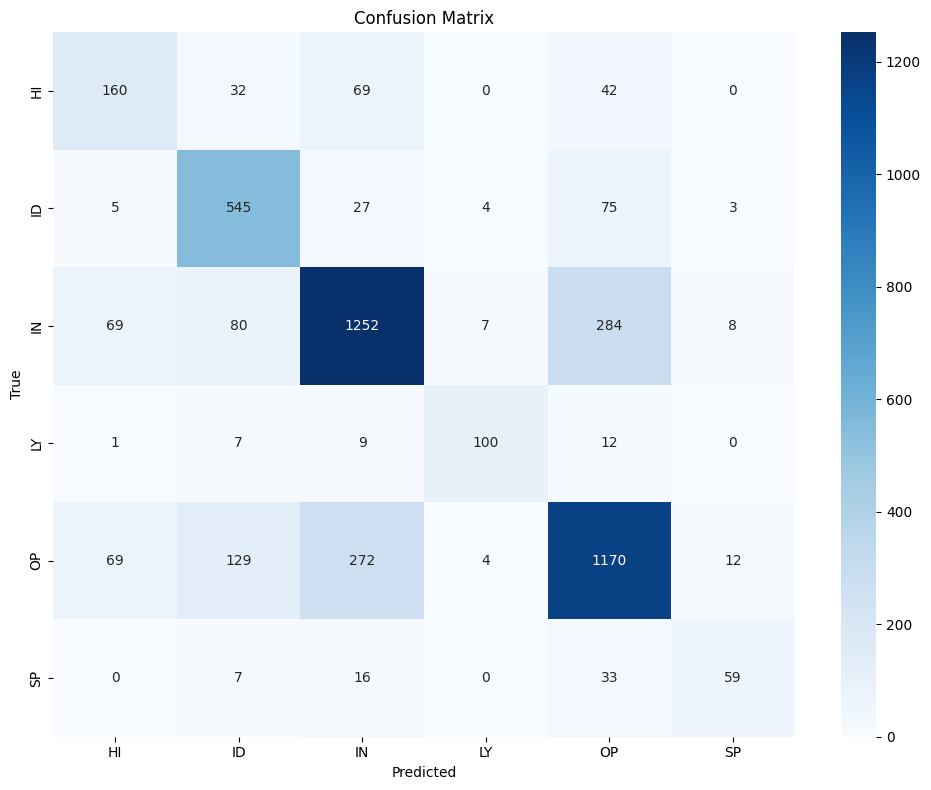

In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ColabNotebooks/Project_D/machine_learning/confusion_matrix.png", dpi=600)
plt.show()

In [ ]:
def predict_text(model_pipeline, text):
    pred_code = model_pipeline.predict([text])[0]
    return le.inverse_transform([pred_code])[0]


In [ ]:
n = 1
# text = dev['content'].iloc[n]
text = test_data['content_cleaned'].iloc[n]
pred = predict_text(best_model, text)
# true_label = le.inverse_transform([y_test[n]])[0]
true_label = dev['category_code'].iloc[n]

print("\n Example Prediction")
print(f"Predicted Category: {pred}")
print(f"True Category: {true_label}")

KeyError: 'content_cleaned'